# Лабораторная работа №2: Дискретное преобразование Фурье

#### Выполнил студент гр. 9381 Семенов Александр, вариант 15.

## Цель работы
#### Практическое применение дискретного преобразования Фурье c использованием библиотек Python для анализа речевых сигналов.

## Задачи лабораторной работы

##### 1. Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса.
##### 2. Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса
##### 3. Построить сонограмму по записи своего голоса.
##### Замечание: Все пункты лабораторной работы выполняем анализом спектра, без использования методов библиотек Librosa и OpenSMILE. Библиотечные методы полезно использовать для проверки полученных результатов.

## Данные для работы

##### 1. Средствами ОС Windows записать свой речевой сигнал.
##### 2. Фраза: Добрый день, я учусь в университете ЛЭТИ, на факультете компьютерных технологий и информатики.
##### 3. Формат записи— моно-сигнал, 16000 гц или 22000 гц, без сжатия (wav-формат).

## Теория по ДПФ

**Сигнал** - последовательность $N$ комплексных чисел: $x = \{x_j\}_{j=0}^{N-1}$, продолженная периодически на все целые индексы, то есть: $x_{j+sN} = x_j$ $\forall s \in \mathbb{Z}$.

**Единичный N-периодический импульс** - сигнал $\delta_N$:

$ \delta_N(j) =
  \begin{cases}
    1, & \quad j \vdots N \\
    0, & \quad иначе
  \end{cases}
$.

**Дискретное преобразование Фурье:** $X(k) = \displaystyle\sum_{j=0}^{N-1} x(j) \omega_N^{-kj}$,  $k \in \mathbb{Z}$, 
где $\omega_N = e^{i \frac{2 \pi}{N}}$ - корень N-й степени из единицы,
$X(k)$ - **спектор Фурье**.

**Обратное преобразование Фурье:** $x(j) = \displaystyle \frac{1}{N} \sum_{k=0}^{N-1} X(k) \omega_N^{kj}$,  $j \in \mathbb{Z}$

**Основные свойства ДПФ:**
- Сигнал $x \in \mathbb{C}_N$ являеся вещественным $(Im(x) = 0)$ $\iff$ его спектр Фурье четный $(X(-k) = \bar{X}(k))$;

- Сигнал $x \in \mathbb{C}_N$ являеся четным $(x(-j) = \bar{x}(j))$ $\iff$ его спектр Фурье вещественный $(Im(X) = 0)$;

## Выполнение работы

### 1. Построение траектории основного тона (F0).
#### Основные теоретические положения:
**Частота сновного тона (F0)** - частота вибрации голосовых связок (первая форманта). У каждого говорящего - индифидуальна. Различна для мужских (80 - 200 Hz) и женских (160 - 350 Hz) голосов.

**Форманты** - пики в огибающей спектра звука, создоваемые акустическими резонансами в голосовом тракте: F0, F1, F2. F3. Амплитуда каждой последующей форманты ниже, чем предыдущей, а их частоты примерно рывны частоте основного тона, умноженной на целое число: 

$F1 \approx 2F0$, $F2 \approx 3F0$, $F3 \approx 4F0$.

**Начальные данные построения:**
1. Пусть частота дискретизации синала - $F_d$ Hz.
2. Выберем $N= 1024$ - размерность  ДПФ. Для перевода частоты $f_i$ в отсчет амплитудного спектра $n_i$, используется формула: $n_i = \displaystyle\bigg\lbrack \frac{f_i}{S_r} \bigg\rbrack$, где $S_r = \displaystyle\frac{F_d}{N}$ - текущее спектральное разрешение.

#### Реализация:

1) Построение графика сигнала:

<ipython-input-64-19d7a306e7ce>:5: WavFileWarning:

Chunk (non-data) not understood, skipping it.



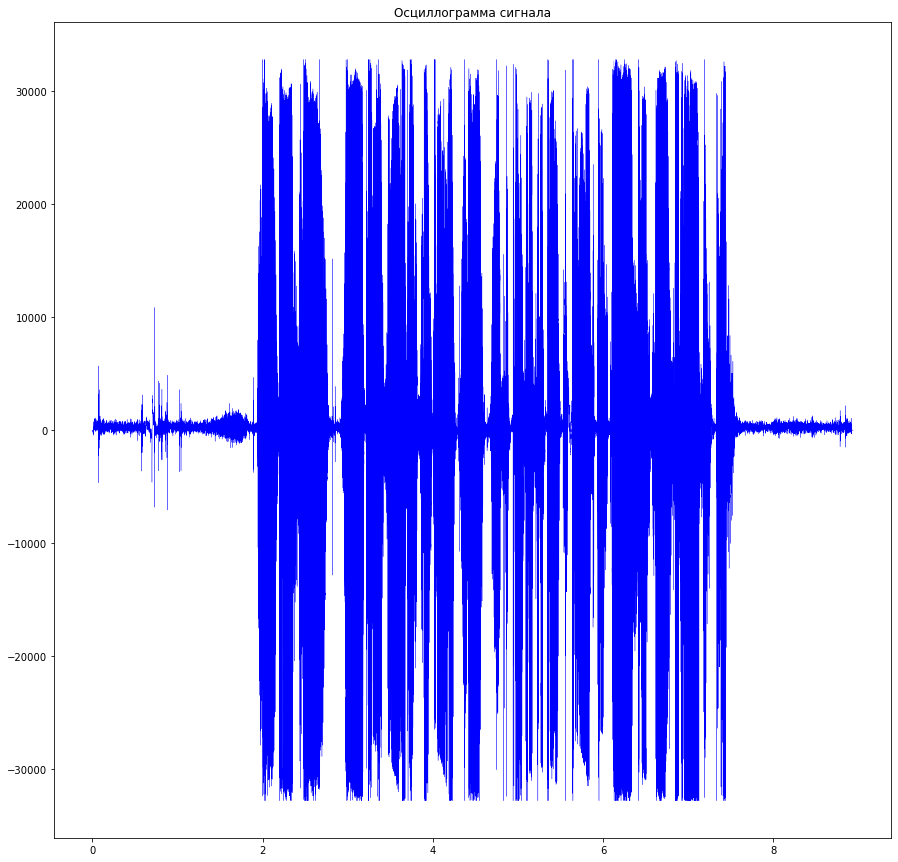

In [64]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import numpy as np

rate, data = read("./myVoice.wav")
time = np.linspace(0, len(data) / rate, num = len(data))
plt.figure(figsize = [15, 15])
plt.plot(time, data, color = 'blue',  linewidth = 0.3)
plt.title("Осциллограмма сигнала")
plt.show()

2) Построение амплитудного спектра сигнала:

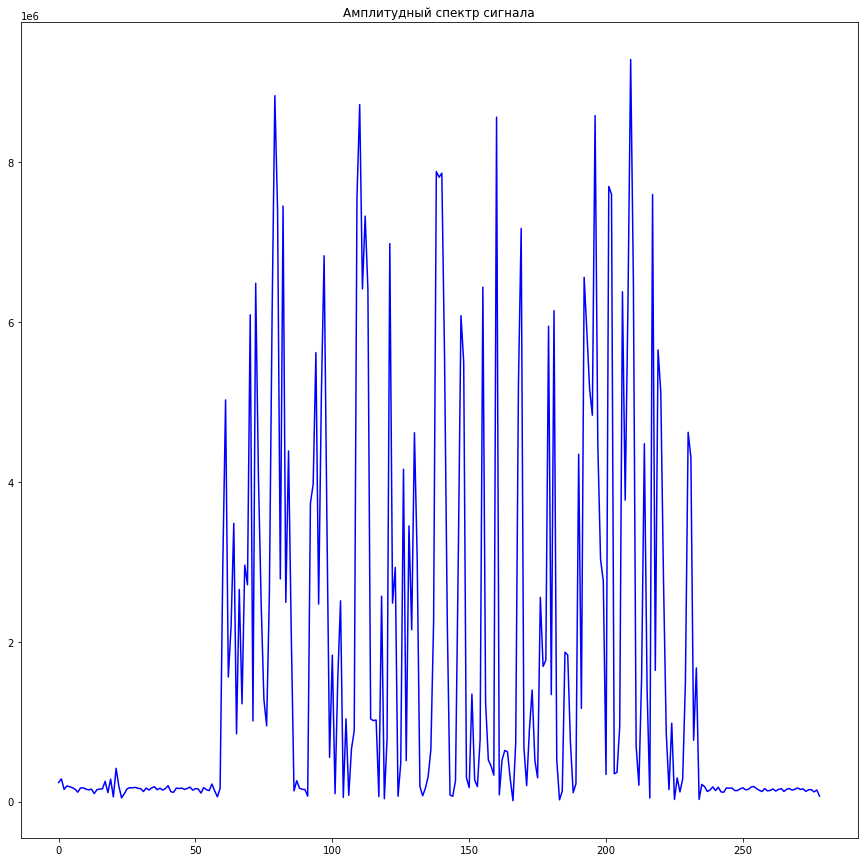

In [65]:
import more_itertools as mi

def DPF(interval):
    interval = np.asarray(interval, dtype=float)
    N = interval.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    return np.dot(np.exp(-2j * np.pi * k * n / N), interval)

N = 1024
spectrRes = round(rate / N)

intervals = list(mi.windowed(data, n=N, step=int(0.5*N)))
intervals[-1] = [i for i in intervals[-1] if i != None]
intervals = [i * np.hamming(len(i)) for i in intervals]

intervals = [DPF(i) for i in intervals]
amplitudeSpectr = [sum([j**2 for j in i[:int(len(i)/2)]])**0.5 for i in intervals]
amplitudeSpectr = np.array([i.real for i in amplitudeSpectr])
plt.figure(figsize = [15, 15])
plt.plot(amplitudeSpectr, color = 'blue')
plt.title("Амплитудный спектр сигнала")
plt.show()

2) Построение траектории основного тона:

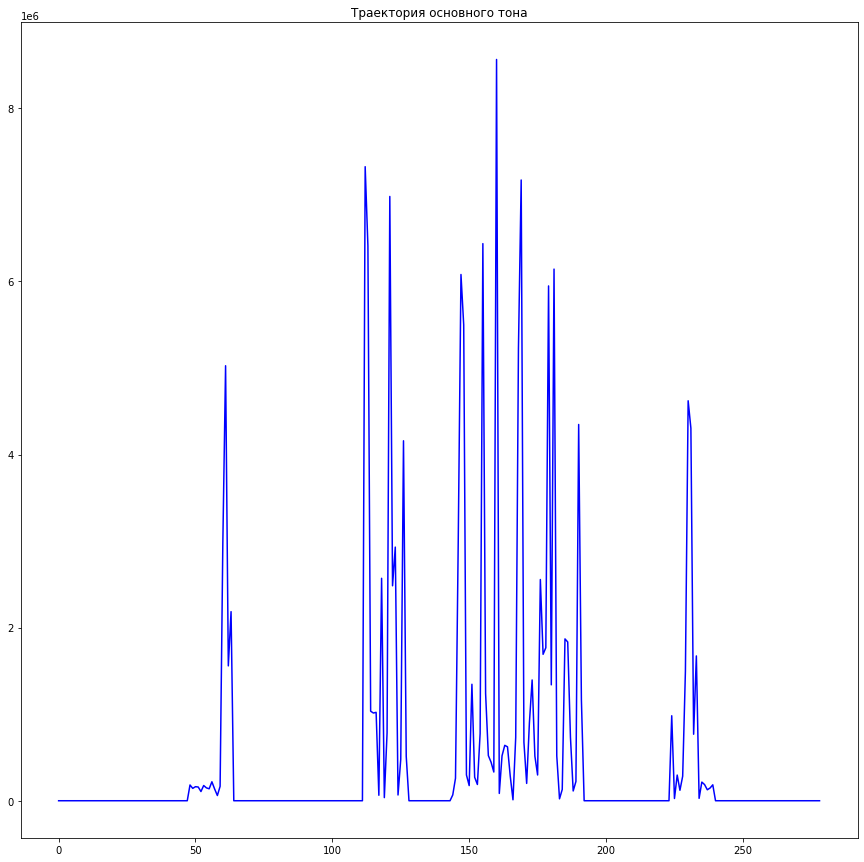

In [66]:
F0 = []
p = list(mi.windowed(amplitudeSpectr, n = round(rate/N), step  = round(rate/N)))
p[-1] = [i for i in p[-1] if i]
for i in range(len(p)):
    p[i] = list(p[i])
for i in p:
    s = np.array(i)
    if s.max() > 3 * s.mean():            
        F0 += s.tolist()
    else:
        F0 += [0 for j in range(len(s))]

plt.figure(figsize = [15, 15])
plt.plot(F0, color = 'blue')
plt.title("Траектория основного тона")
plt.show()

### 2. Построение траекторий второй (F1), третей (F2) и четвертой (F3) формантных частот.

#### Реализация:
1) Функция построения частот:

In [67]:
def formantRateConstruct(F, F0, k):
    for i in range(len(F0) // k):
        maximum = max([F0[k*i], F0[k*i-1], F0[k*i+1]])
        if F0[i] > maximum * 2**(k-1):
            F.append(maximum)
        else:
            F.append(0)

1) Построение траектории второй формантной частоты:

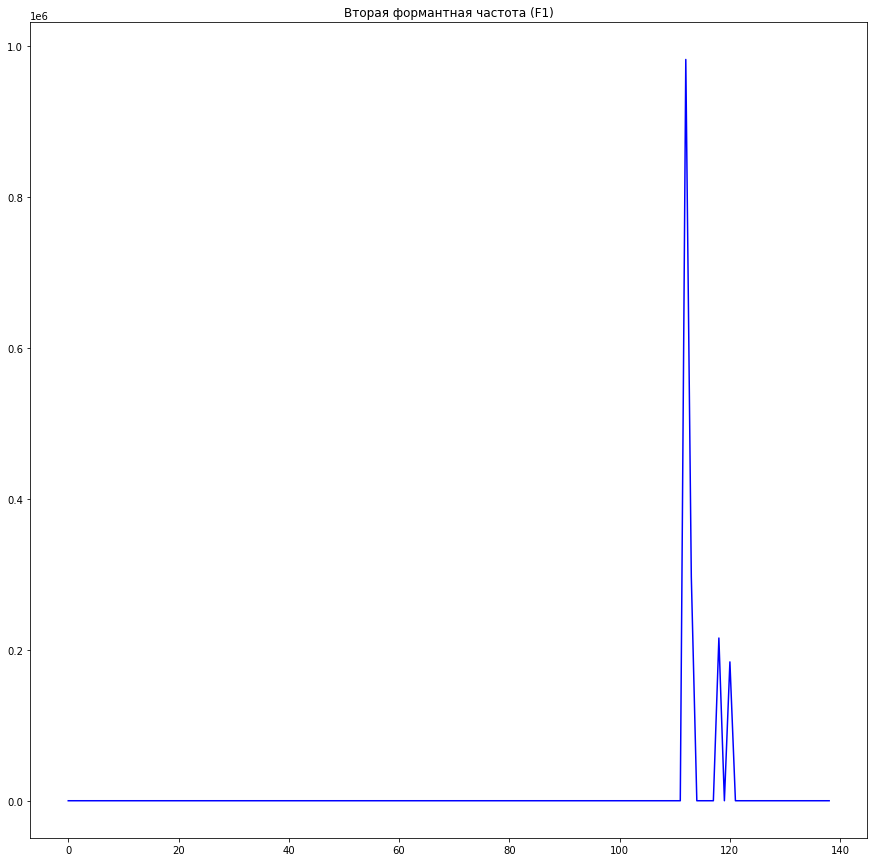

In [68]:
F1 = []
formantRateConstruct(F1, F0, 2)
plt.figure(figsize = [15, 15])
plt.plot(F1, color = 'blue')
plt.title("Вторая формантная частота (F1)")
plt.show()

2) Построение траектории третей формантной частоты:

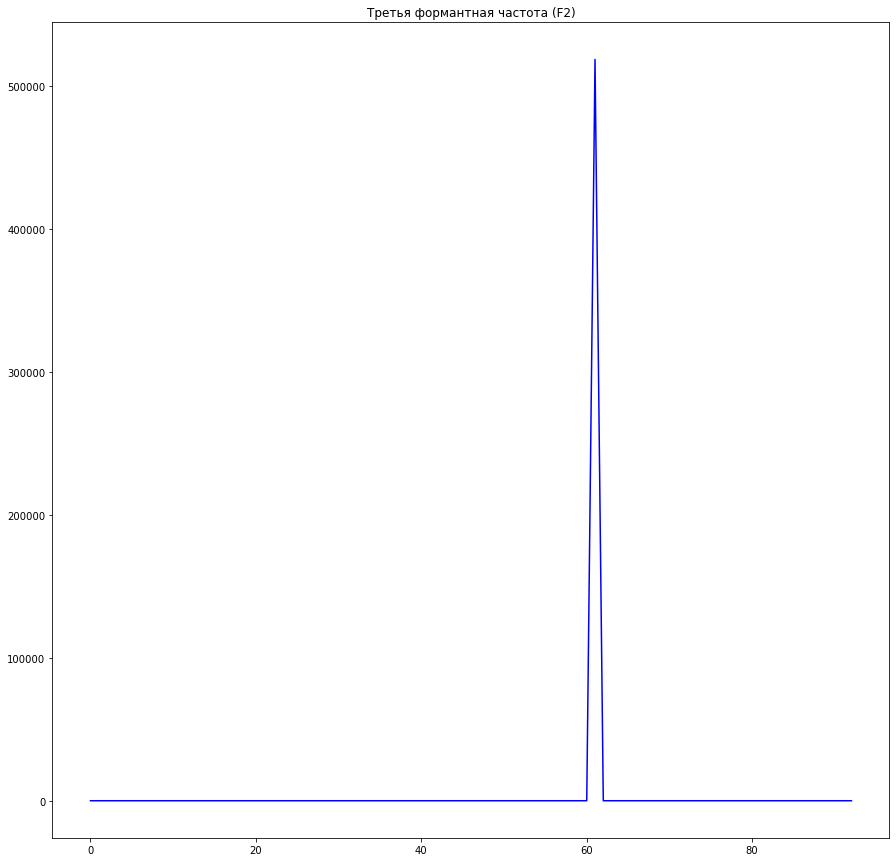

In [69]:
F2 = []
formantRateConstruct(F2, F0, 3)
plt.figure(figsize = [15, 15])
plt.plot(F2, color = 'blue')
plt.title("Третья формантная частота (F2)")
plt.show()

3) Построение траектории четвертой формантной частоты:

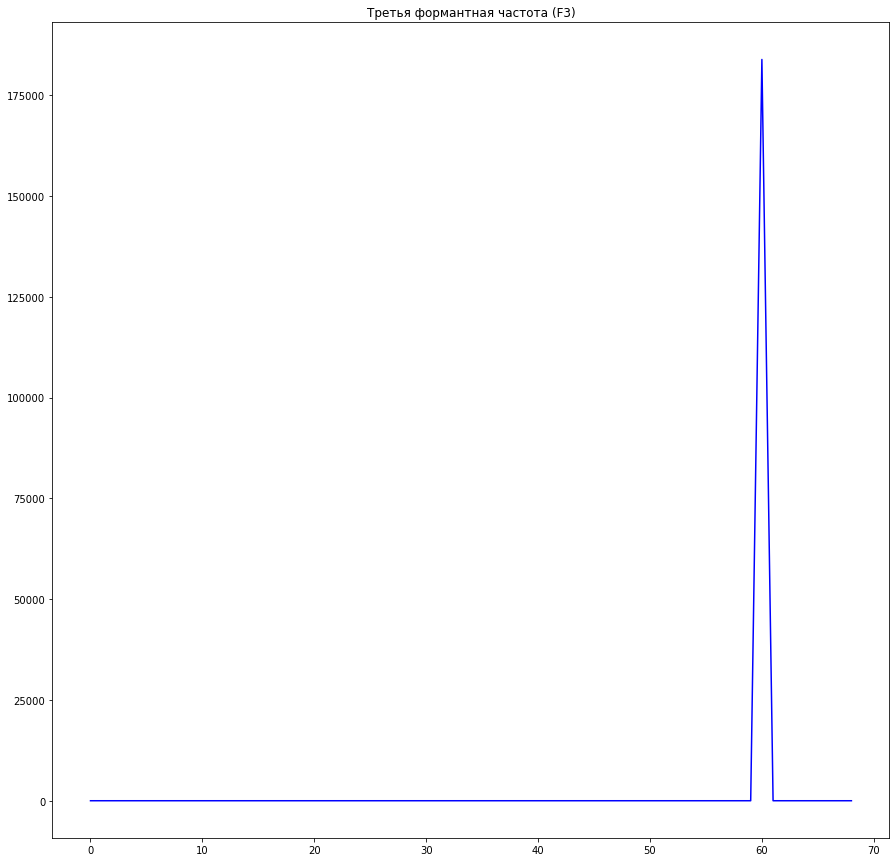

In [70]:
F3 = []
formantRateConstruct(F3, F0, 4)
plt.figure(figsize = [15, 15])
plt.plot(F3, color = 'blue')
plt.title("Третья формантная частота (F3)")
plt.show()

### 3. Построение сонограммы

#### Основные теоретические положения:

**Сонограмма** - это изображение кратковременного спектра сигнала (спектров на последовательности кадров) в координатах времени (горизонтальная ось), частоты (вертикальная ось) и энергии голоса (степень зачернения, цвет). Интенсивность темного (или цвета) отображает амплитуду спектра. Наиболее темные горизонтальные полосы частот показывают спектральные максимумы.

**Алгоритм построения:**

1 Повторяем первые три шага алгоритма вычисления $F0$.

2 Находим максимальное значение амплитудного спектра для $F0$ по всему сигналу — $A_{Max}$.

3 Интенсивность темного (или цвета) определяем относительно значения $A_{Max}$.

4 Интенсивность столбца значений амплитудного спектра выводим в интервале $50 − 4000$ Hz.

5 Размерность столбца определяется пользователем.


#### Реализация:

In [71]:
sonogramMatrix = []

for i in range(0, len(amplitudeSpectr), spectrRes): 
    sonogramMatrix.append(list(amplitudeSpectr[i:i+spectrRes]))

sonogramMatrix = np.array(sonogramMatrix[:-1])
sonogramMatrix.reshape(len(sonogramMatrix), len(sonogramMatrix[0]))


figure = px.imshow(sonogramMatrix)
figure.show()

## Вывод
#### В ходе выполнения лабораторной работы было изучено дискретное преобразование Фурье и его свойства, приобретены навыки в анализе речевого сигнала с помощью библиотек Python, а также решены следующие задачи:
- __Запись собственного голоса в wav-формате и его анализ с помощью ДПФ__;
- __Построение траектории основного тона (F0) на записи своего голоса;__
- __Построение траектории второй, третей и четвертой формантных частот на записи своего голоса с помощью ДПФ;__
- __Построение сонограммы по записи своего голоса.__